## ARMA Models

In [1]:
import time 

import matplotlib.pyplot as plt 
import pandas as pd
import plotly.express as px
import seaborn as sns 
from pymongo import  MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import  plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA 

#### Prepare Data

In [ ]:
client = MongoClient(host="localhost", port = 27017)
db = client["air-quality"]
nairobi = db["nairobi"]

In [ ]:
def wrangle(collection, resample_rule="1H"):

    results = collection.find(
        {"metadata.site": 29, "metadata.measurement": "P2"},
        projection={"P2": 1, "timestamp": 1, "_id": 0},
    )

    # Read results into DataFrame
    df = pd.DataFrame(list(results)).set_index("timestamp")

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample and forward-fill
    y = df["P2"].resample(resample_rule).mean().fillna(method="ffill")

    return y

In [21]:
df = pd.read_csv("data/nairobi-city-air-quality.csv").set_index("timestamp")
df.dropna(inplace=True)
df = df[df["P2"] < 500]
y = df["P2"]
y

timestamp
09/01/2018 00:00       34.43
09/01/2018 00:05       30.53
09/01/2018 00:10       22.80
09/01/2018 00:15       13.30
09/01/2018 00:20       16.57
                       ...  
12/31/2018 23:35:06    21.92
12/31/2018 23:40:06    20.83
12/31/2018 23:45:05    19.12
12/31/2018 23:50:05    19.10
12/31/2018 23:55:05    17.60
Name: P2, Length: 32906, dtype: float64

#### Explore

ACF plot

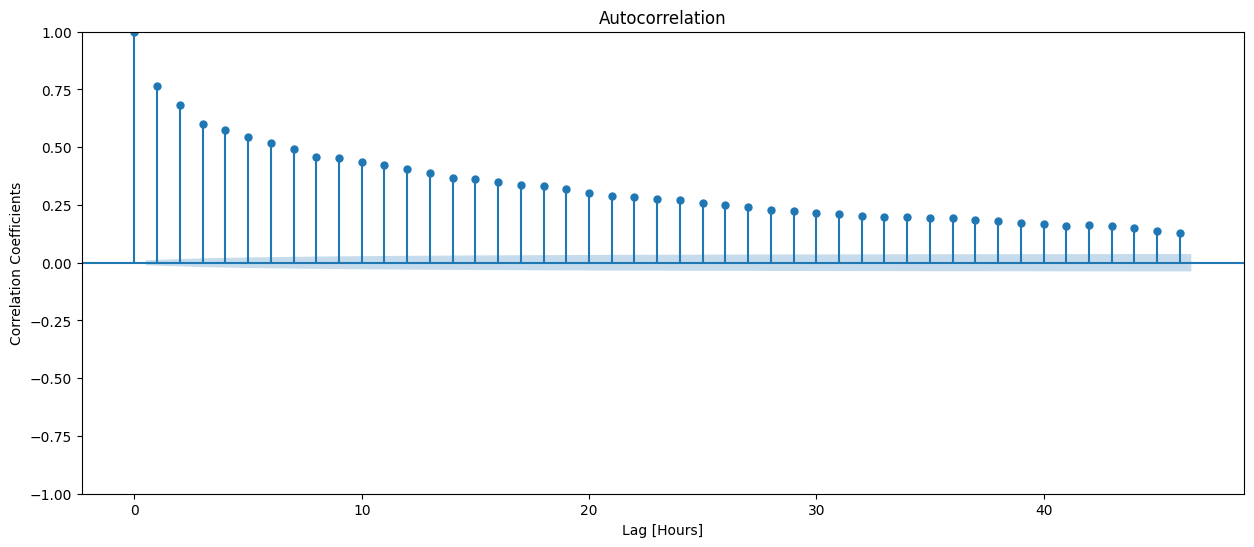

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficients");

PACF Plot

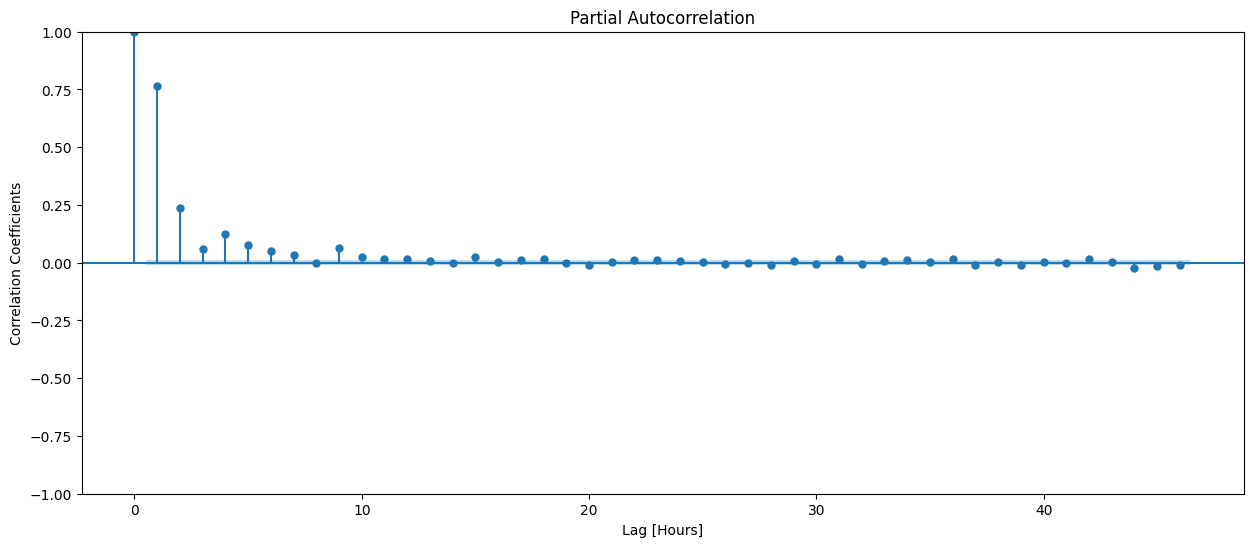

In [23]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correlation Coefficients");

Split into Test and Traiaan sets:

In [24]:
cutoff_test = int(len(y) * 0.25)
y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

Build Model:

Baseline Model

In [25]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.05
Baseline MAE: 4.51


Iterate: 

In [26]:
p_params = range(0, 25, 8)
q_params = range(0, 3, 1)

MAE Grid:

In [ ]:
mae_grid = {}
for p in p_params:
    mae_grid[p] = []
    for q in q_params:
        order = (p, 0, q)
        start_time=time.time()
        model = ARIMA(y_train, order=order).fit()
        elapsed_time=round(time.time() - start_time, 2)
        print(f"Trained ARIMA model {order} in {elapsed_time} seconds")
        y_pred = model.predict()
        mae=round(mean_absolute_error(y_train, y_pred), 2)
        mae_grid[p].append(mae)
        print(f"Training ame is {mae}")

In [28]:
mae_grid = {0: [4.21, 3.05, 2.68],
 8: [2.45, 2.41, 2.43],
 16: [2.38, 2.38, 2.38],
 24: [2.38, 2.4, 2.41]}

In [29]:
# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ...
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        y_pred = ...
        # Calculate training MAE
        mae = ...
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()
print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.0 seconds.
Trained ARIMA (0, 0, 1) in 0.0 seconds.
Trained ARIMA (0, 0, 2) in 0.0 seconds.
Trained ARIMA (8, 0, 0) in 0.0 seconds.
Trained ARIMA (8, 0, 1) in 0.0 seconds.
Trained ARIMA (8, 0, 2) in 0.0 seconds.
Trained ARIMA (16, 0, 0) in 0.0 seconds.
Trained ARIMA (16, 0, 1) in 0.0 seconds.
Trained ARIMA (16, 0, 2) in 0.0 seconds.
Trained ARIMA (24, 0, 0) in 0.0 seconds.
Trained ARIMA (24, 0, 1) in 0.0 seconds.
Trained ARIMA (24, 0, 2) in 0.0 seconds.

{0: [Ellipsis, Ellipsis, Ellipsis], 8: [Ellipsis, Ellipsis, Ellipsis], 16: [Ellipsis, Ellipsis, Ellipsis], 24: [Ellipsis, Ellipsis, Ellipsis]}


Mae grid into a df:

In [30]:
mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,Ellipsis,Ellipsis,Ellipsis,Ellipsis
1,Ellipsis,Ellipsis,Ellipsis,Ellipsis
2,Ellipsis,Ellipsis,Ellipsis,Ellipsis


Heat Map:

In [ ]:
sns.heatmap(mae_df, cmap="Blues")
plt.xlabel("P Values")
plt.ylabel("q Valies")
plt.title("ARIMA Grid Search (Criterion: MAE");

Diagnostic plot:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig=fig);

#### Evaluate

In [ ]:
y_pred_wfv = pd.Series()
history = y_train.copy()
for i in range(len(y_test)):
    model = ARIMA(history, order=(0, 0, 1)).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])

In [ ]:
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

#### Communicate Results

In [ ]:
df_predictions = pd.DataFrame({":y_test":y_test, "y_pred_wfv":y_pred_wfv})
fig = px.line(df_predictions, labels={"value":"PM2.5"})
fig.show();